# ARC Prize 2025 Data Exploration

This notebook provides a comprehensive exploration of the Abstraction and Reasoning Corpus (ARC) dataset for the ARC Prize 2025 competition.

The objective of this competition is to create an algorithm capable of solving abstract reasoning tasks. These are novel tasks that require understanding patterns and applying them to new inputs.

## Dataset Structure
Each task contains:
- Training pairs (input/output examples)
- Test inputs (for which we need to predict outputs)

The grids are represented as 2D arrays with integers from 0-9, which are visualized as colors.

In [1]:
# Import necessary libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.colors import ListedColormap
import random
from collections import defaultdict, Counter
from typing import Dict, List, Any, Tuple
from IPython.display import display, HTML

# Set up visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define ARC color map (0-9)
CMAP = ListedColormap([
    '#000000', '#0074D9', '#FF4136', '#2ECC40', 
    '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', 
    '#7FDBFF', '#870C25'
])

# Define paths to data files
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'Arc_Prize', 'arc-prize-2025')
TRAINING_CHALLENGES_PATH = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
TRAINING_SOLUTIONS_PATH = os.path.join(DATA_DIR, 'arc-agi_training_solutions.json')
EVAL_CHALLENGES_PATH = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
EVAL_SOLUTIONS_PATH = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')
TEST_CHALLENGES_PATH = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')

print("Data directory:", DATA_DIR)
print("Files exist check:")
print(f"Training challenges: {os.path.exists(TRAINING_CHALLENGES_PATH)}")
print(f"Training solutions: {os.path.exists(TRAINING_SOLUTIONS_PATH)}")
print(f"Evaluation challenges: {os.path.exists(EVAL_CHALLENGES_PATH)}")
print(f"Evaluation solutions: {os.path.exists(EVAL_SOLUTIONS_PATH)}")
print(f"Test challenges: {os.path.exists(TEST_CHALLENGES_PATH)}")

Data directory: c:\Users\barad\OneDrive\Desktop\ARC\Arc_Prize\arc-prize-2025
Files exist check:
Training challenges: True
Training solutions: True
Evaluation challenges: True
Evaluation solutions: True
Test challenges: True


## Loading and Examining the Data

Let's load the ARC data files and examine their structure.

In [2]:
# Load the data files
def load_json(filepath):
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return {}

# Load all datasets
training_challenges = load_json(TRAINING_CHALLENGES_PATH)
training_solutions = load_json(TRAINING_SOLUTIONS_PATH)
eval_challenges = load_json(EVAL_CHALLENGES_PATH)
eval_solutions = load_json(EVAL_SOLUTIONS_PATH)
test_challenges = load_json(TEST_CHALLENGES_PATH)

print(f"Loaded {len(training_challenges)} training tasks")
print(f"Loaded {len(training_solutions)} training solutions")
print(f"Loaded {len(eval_challenges)} evaluation tasks")
print(f"Loaded {len(eval_solutions)} evaluation solutions")
print(f"Loaded {len(test_challenges)} test tasks")

Loaded 1000 training tasks
Loaded 1000 training solutions
Loaded 120 evaluation tasks
Loaded 120 evaluation solutions
Loaded 240 test tasks


In [3]:
# Examine the structure of a random training task
def examine_task_structure(task_dict):
    random_task_id = random.choice(list(task_dict.keys()))
    task = task_dict[random_task_id]
    
    print(f"Task ID: {random_task_id}")
    print(f"Task structure keys: {list(task.keys())}")
    print(f"Number of training pairs: {len(task['train'])}")
    
    # Examine the first training pair
    first_pair = task['train'][0]
    print(f"\nTraining pair keys: {list(first_pair.keys())}")
    
    # Examine the input grid
    input_grid = first_pair['input']
    print(f"\nInput grid shape: {len(input_grid)} rows x {len(input_grid[0])} columns")
    print("Input grid:")
    for row in input_grid:
        print(row)
    
    # Examine the output grid
    output_grid = first_pair['output']
    print(f"\nOutput grid shape: {len(output_grid)} rows x {len(output_grid[0])} columns")
    print("Output grid:")
    for row in output_grid:
        print(row)
    
    # Examine the test input
    test_input = task['test']
    print(f"\nTest input shape: {len(test_input)} rows x {len(test_input[0])} columns")
    print("Test input:")
    for row in test_input:
        print(row)
    
    # Return the task ID for future reference
    return random_task_id

# Examine a random training task
random_task_id = examine_task_structure(training_challenges)

Task ID: 694f12f3
Task structure keys: ['train', 'test']
Number of training pairs: 2

Training pair keys: ['input', 'output']

Input grid shape: 10 rows x 10 columns
Input grid:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 4, 4, 4, 4, 0]
[0, 0, 0, 0, 0, 4, 4, 4, 4, 0]
[0, 0, 0, 0, 0, 4, 4, 4, 4, 0]

Output grid shape: 10 rows x 10 columns
Output grid:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 4, 2, 2, 2, 4, 0, 0, 0, 0]
[0, 4, 2, 2, 2, 4, 0, 0, 0, 0]
[0, 4, 2, 2, 2, 4, 0, 0, 0, 0]
[0, 4, 4, 4, 4, 4, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 4, 4, 4, 4, 0]
[0, 0, 0, 0, 0, 4, 1, 1, 4, 0]
[0, 0, 0, 0, 0, 4, 4, 4, 4, 0]

Test input shape: 1 rows x 1 columns
Test input:
{'input': [[4, 4, 4, 4, 4, 4, 0, 0, 0, 0], [4, 4, 4, 4, 4, 4, 0, 0, 0, 0], [4, 4, 4, 4, 4, 4, 0, 0

## Visualization Functions

Let's create functions to visualize the ARC tasks. This will help us understand the patterns and transformations better.

Attempting to visualize task with ID: 694f12f3
Task structure: <class 'dict'>
Task keys: ['train', 'test']


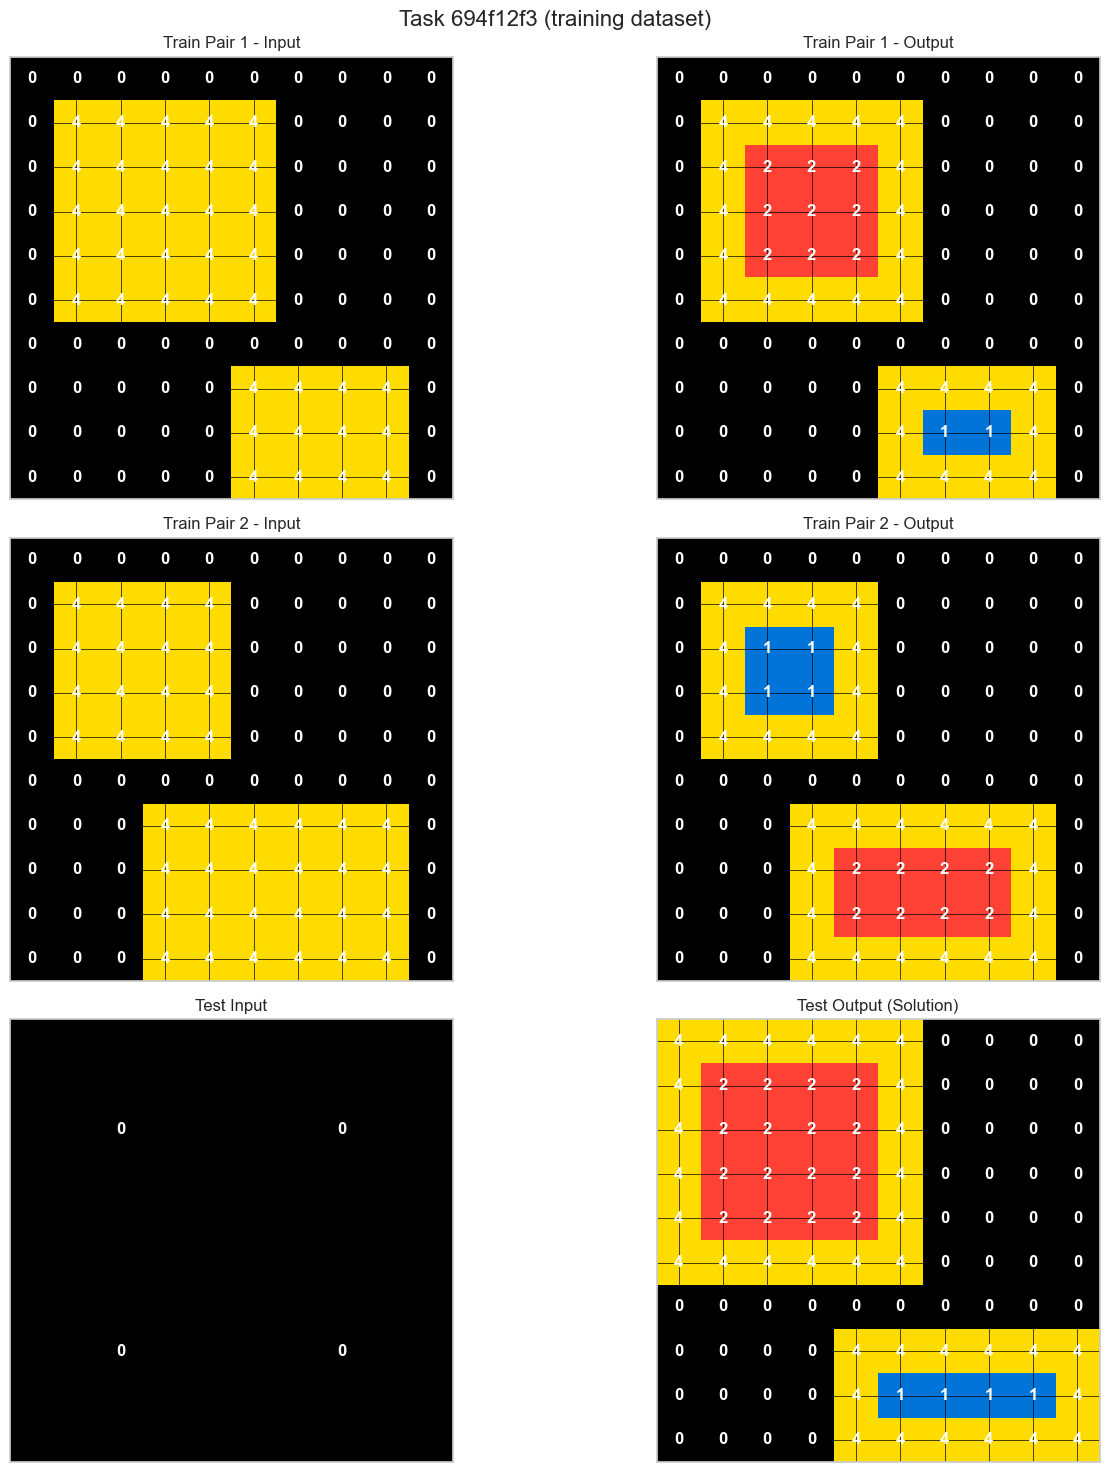

In [5]:
def plot_grid(grid, ax=None, title=None):
    """Plot a grid using the ARC color scheme."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    # Convert grid to numpy array and ensure it's numeric
    try:
        grid_array = np.array(grid, dtype=np.int32)
    except (ValueError, TypeError):
        # Handle case where grid might contain non-numeric elements
        print(f"Warning: Grid contains non-numeric elements: {grid}")
        # Create a placeholder grid for visualization
        grid_array = np.zeros((2, 2), dtype=np.int32)
    
    ax.imshow(grid_array, cmap=CMAP, vmin=0, vmax=9)
    
    # Add grid lines
    ax.grid(color='black', linestyle='-', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, grid_array.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_array.shape[0], 1), minor=True)
    
    # Show grid values
    for i in range(grid_array.shape[0]):
        for j in range(grid_array.shape[1]):
            ax.text(j, i, str(grid_array[i, j]), 
                   ha="center", va="center", color="w",
                   fontsize=12, fontweight='bold')
    
    # Adjust axes
    ax.set_xticks(np.arange(0, grid_array.shape[1], 1))
    ax.set_yticks(np.arange(0, grid_array.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if title:
        ax.set_title(title)
    
    return ax

def visualize_task(task_id, dataset='training'):
    """Visualize a task with its train pairs and test input."""
    # Select the appropriate dataset
    if dataset == 'training':
        challenges = training_challenges
        solutions = training_solutions
    elif dataset == 'eval':
        challenges = eval_challenges
        solutions = eval_solutions
    elif dataset == 'test':
        challenges = test_challenges
        solutions = None  # No solutions for test set
    else:
        print(f"Unknown dataset: {dataset}")
        return
    
    # Check if the task exists
    if task_id not in challenges:
        print(f"Task {task_id} not found in {dataset} dataset")
        return
    
    task = challenges[task_id]
    
    # Print task structure for debugging
    print(f"Task structure: {type(task)}")
    print(f"Task keys: {list(task.keys())}")
    
    # Calculate the number of rows and columns needed for the plot
    train_pairs = task['train']
    num_train_pairs = len(train_pairs)
    
    # Create a figure with subplots for train pairs and test input
    fig = plt.figure(figsize=(15, 5 * (num_train_pairs + 1)))
    fig.suptitle(f"Task {task_id} ({dataset} dataset)", fontsize=16)
    
    # Plot train pairs
    for i, pair in enumerate(train_pairs):
        # Input grid
        ax_input = fig.add_subplot(num_train_pairs + 1, 2, i * 2 + 1)
        plot_grid(pair['input'], ax_input, title=f"Train Pair {i+1} - Input")
        
        # Output grid
        ax_output = fig.add_subplot(num_train_pairs + 1, 2, i * 2 + 2)
        plot_grid(pair['output'], ax_output, title=f"Train Pair {i+1} - Output")
    
    # Plot test input - check if it's a valid grid
    if 'test' in task:
        if isinstance(task['test'], list):
            ax_test = fig.add_subplot(num_train_pairs + 1, 2, num_train_pairs * 2 + 1)
            plot_grid(task['test'], ax_test, title="Test Input")
        else:
            print(f"Warning: Test input is not a grid: {task['test']}")
    else:
        print("Warning: No test input found in task")
    
    # Plot test output (solution) if available
    if solutions and task_id in solutions:
        if isinstance(solutions[task_id], list) and solutions[task_id]:
            test_output = solutions[task_id][0]  # Assuming first solution
            ax_test_output = fig.add_subplot(num_train_pairs + 1, 2, num_train_pairs * 2 + 2)
            plot_grid(test_output, ax_test_output, title="Test Output (Solution)")
        else:
            print(f"Warning: Solution format unexpected: {solutions[task_id]}")
    
    plt.tight_layout()
    plt.show()

# Visualize the random task we examined earlier
print(f"Attempting to visualize task with ID: {random_task_id}")
visualize_task(random_task_id, 'training')

## Basic Dataset Statistics

Let's analyze some basic statistics of the ARC datasets to understand their characteristics.

In [6]:
def analyze_dataset_stats(dataset='training'):
    """Analyze basic statistics of a dataset."""
    # Select the appropriate dataset
    if dataset == 'training':
        challenges = training_challenges
    elif dataset == 'eval':
        challenges = eval_challenges
    elif dataset == 'test':
        challenges = test_challenges
    else:
        print(f"Unknown dataset: {dataset}")
        return
    
    # Initialize statistics
    num_tasks = len(challenges)
    train_examples_counts = []
    input_grid_sizes = []
    output_grid_sizes = []
    input_heights = []
    input_widths = []
    output_heights = []
    output_widths = []
    symbols_used = defaultdict(int)
    
    # Collect statistics
    for task_id, task in challenges.items():
        train_pairs = task['train']
        train_examples_counts.append(len(train_pairs))
        
        # Analyze train pairs
        for pair in train_pairs:
            input_grid = pair['input']
            output_grid = pair['output']
            
            # Grid sizes
            input_height = len(input_grid)
            input_width = len(input_grid[0])
            output_height = len(output_grid)
            output_width = len(output_grid[0])
            
            input_grid_sizes.append((input_height, input_width))
            output_grid_sizes.append((output_height, output_width))
            
            input_heights.append(input_height)
            input_widths.append(input_width)
            output_heights.append(output_height)
            output_widths.append(output_width)
            
            # Symbols used
            for row in input_grid:
                for cell in row:
                    symbols_used[cell] += 1
            for row in output_grid:
                for cell in row:
                    symbols_used[cell] += 1
    
    # Print statistics
    print(f"\n=== {dataset.upper()} DATASET STATISTICS ===")
    print(f"Number of tasks: {num_tasks}")
    print(f"Average train examples per task: {np.mean(train_examples_counts):.2f}")
    print(f"Min train examples: {min(train_examples_counts)}, Max: {max(train_examples_counts)}")
    
    # Grid size statistics
    print(f"\nInput grid height - Avg: {np.mean(input_heights):.2f}, Min: {min(input_heights)}, Max: {max(input_heights)}")
    print(f"Input grid width - Avg: {np.mean(input_widths):.2f}, Min: {min(input_widths)}, Max: {max(input_widths)}")
    print(f"Output grid height - Avg: {np.mean(output_heights):.2f}, Min: {min(output_heights)}, Max: {max(output_heights)}")
    print(f"Output grid width - Avg: {np.mean(output_widths):.2f}, Min: {min(output_widths)}, Max: {max(output_widths)}")
    
    # Symbols used
    print("\nSymbols frequency:")
    total_symbols = sum(symbols_used.values())
    for symbol, count in sorted(symbols_used.items()):
        print(f"Symbol {symbol}: {count} occurrences ({count/total_symbols*100:.2f}%)")
    
    return {
        'num_tasks': num_tasks,
        'train_examples': train_examples_counts,
        'input_heights': input_heights,
        'input_widths': input_widths,
        'output_heights': output_heights,
        'output_widths': output_widths,
        'symbols_used': symbols_used
    }

# Analyze statistics for training and evaluation datasets
training_stats = analyze_dataset_stats('training')
eval_stats = analyze_dataset_stats('eval')


=== TRAINING DATASET STATISTICS ===
Number of tasks: 1000
Average train examples per task: 3.23
Min train examples: 2, Max: 10

Input grid height - Avg: 11.41, Min: 1, Max: 30
Input grid width - Avg: 11.89, Min: 1, Max: 30
Output grid height - Avg: 9.95, Min: 1, Max: 30
Output grid width - Avg: 10.37, Min: 1, Max: 30

Symbols frequency:
Symbol 0: 509919 occurrences (51.27%)
Symbol 1: 78058 occurrences (7.85%)
Symbol 2: 64134 occurrences (6.45%)
Symbol 3: 58612 occurrences (5.89%)
Symbol 4: 48896 occurrences (4.92%)
Symbol 5: 37383 occurrences (3.76%)
Symbol 6: 23560 occurrences (2.37%)
Symbol 7: 62668 occurrences (6.30%)
Symbol 8: 99251 occurrences (9.98%)
Symbol 9: 12113 occurrences (1.22%)

=== EVAL DATASET STATISTICS ===
Number of tasks: 120
Average train examples per task: 2.98
Min train examples: 2, Max: 6

Input grid height - Avg: 17.40, Min: 4, Max: 30
Input grid width - Avg: 18.39, Min: 3, Max: 30
Output grid height - Avg: 15.44, Min: 2, Max: 30
Output grid width - Avg: 15.72,

## Visualizing Dataset Statistics

Let's create some visualizations to better understand the dataset characteristics.

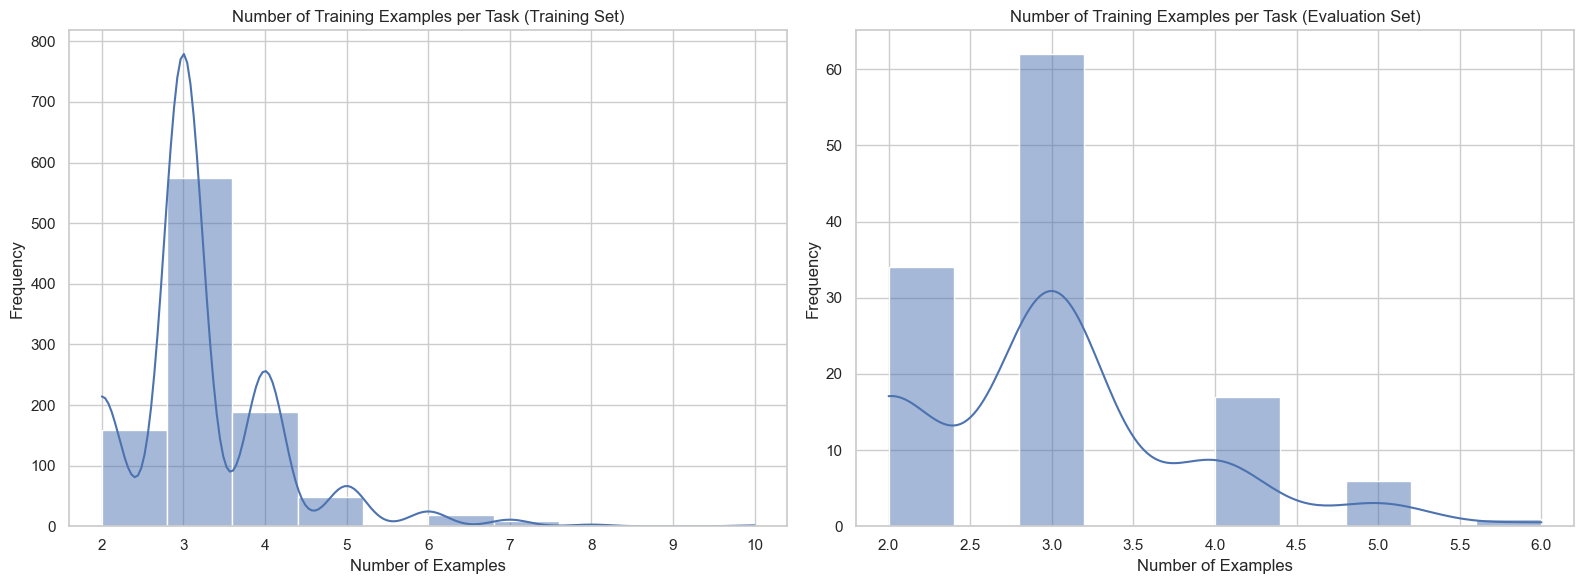

In [7]:
# Plot training examples per task
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(training_stats['train_examples'], kde=True, ax=ax[0], bins=10)
ax[0].set_title('Number of Training Examples per Task (Training Set)')
ax[0].set_xlabel('Number of Examples')
ax[0].set_ylabel('Frequency')

sns.histplot(eval_stats['train_examples'], kde=True, ax=ax[1], bins=10)
ax[1].set_title('Number of Training Examples per Task (Evaluation Set)')
ax[1].set_xlabel('Number of Examples')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

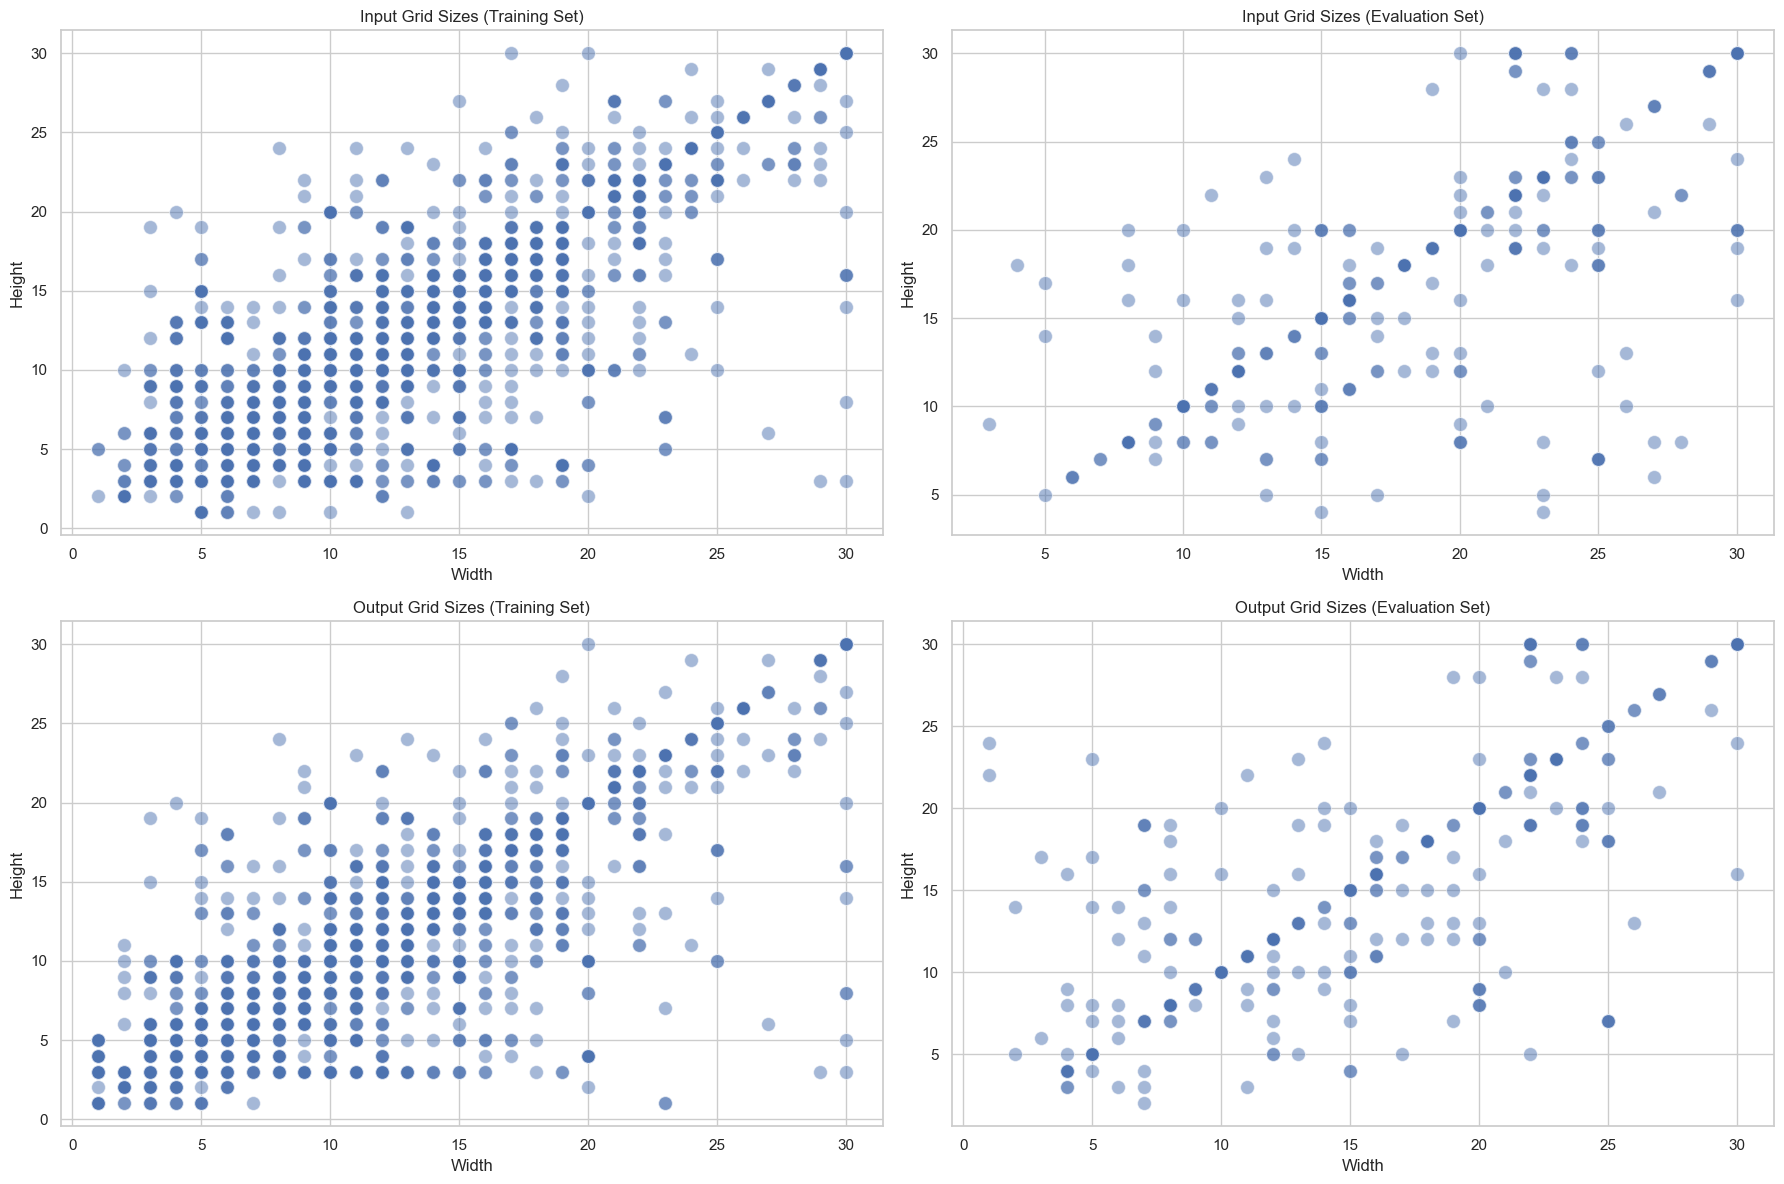

In [8]:
# Plot grid sizes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Input grid sizes
sns.scatterplot(x=training_stats['input_widths'], y=training_stats['input_heights'], 
               alpha=0.5, s=100, ax=axes[0, 0])
axes[0, 0].set_title('Input Grid Sizes (Training Set)')
axes[0, 0].set_xlabel('Width')
axes[0, 0].set_ylabel('Height')
axes[0, 0].grid(True)

sns.scatterplot(x=eval_stats['input_widths'], y=eval_stats['input_heights'], 
               alpha=0.5, s=100, ax=axes[0, 1])
axes[0, 1].set_title('Input Grid Sizes (Evaluation Set)')
axes[0, 1].set_xlabel('Width')
axes[0, 1].set_ylabel('Height')
axes[0, 1].grid(True)

# Output grid sizes
sns.scatterplot(x=training_stats['output_widths'], y=training_stats['output_heights'], 
               alpha=0.5, s=100, ax=axes[1, 0])
axes[1, 0].set_title('Output Grid Sizes (Training Set)')
axes[1, 0].set_xlabel('Width')
axes[1, 0].set_ylabel('Height')
axes[1, 0].grid(True)

sns.scatterplot(x=eval_stats['output_widths'], y=eval_stats['output_heights'], 
               alpha=0.5, s=100, ax=axes[1, 1])
axes[1, 1].set_title('Output Grid Sizes (Evaluation Set)')
axes[1, 1].set_xlabel('Width')
axes[1, 1].set_ylabel('Height')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

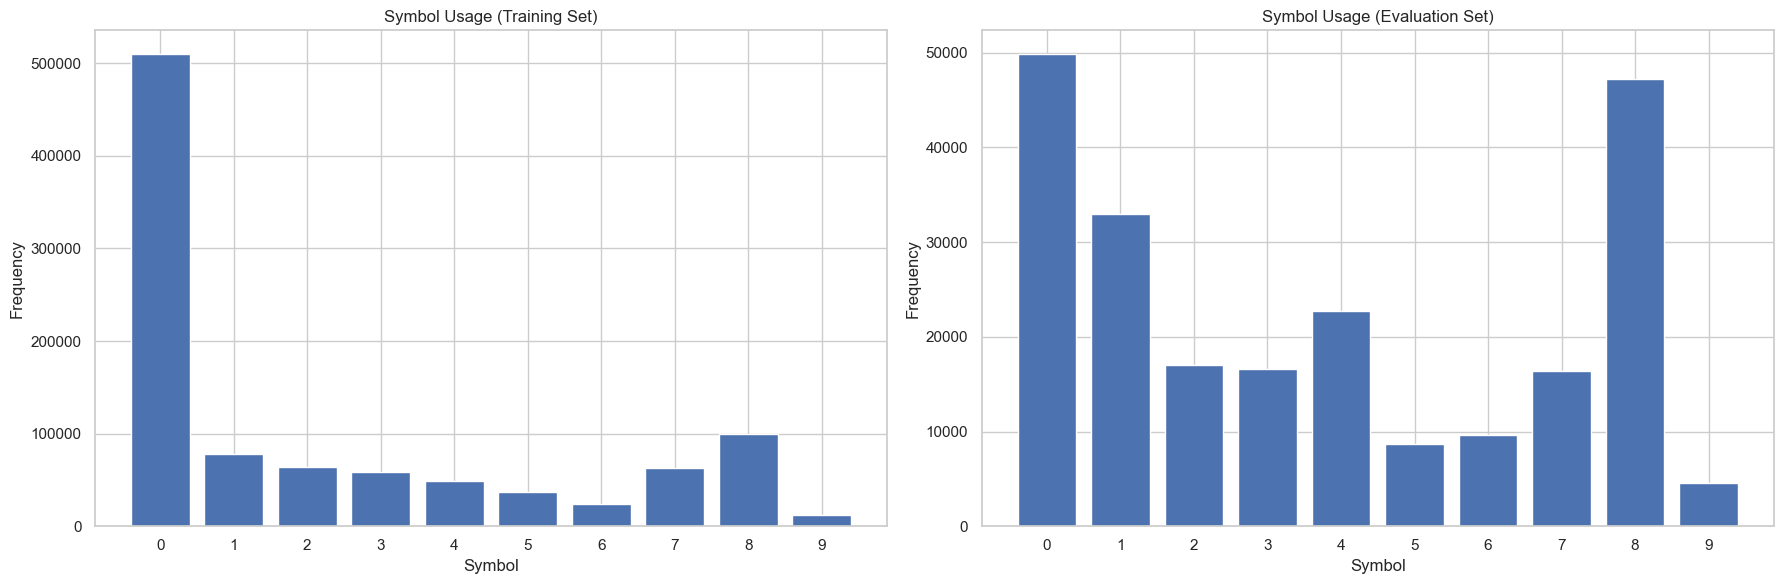

In [9]:
# Plot symbol usage
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Training set symbols
symbols_train = sorted(training_stats['symbols_used'].items())
symbols, counts = zip(*symbols_train)
axes[0].bar(symbols, counts)
axes[0].set_title('Symbol Usage (Training Set)')
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(10))

# Evaluation set symbols
symbols_eval = sorted(eval_stats['symbols_used'].items())
symbols, counts = zip(*symbols_eval)
axes[1].bar(symbols, counts)
axes[1].set_title('Symbol Usage (Evaluation Set)')
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(10))

plt.tight_layout()
plt.show()

## Analyzing Transformation Types

Let's analyze the types of transformations that occur between inputs and outputs in the training examples.

In [10]:
def analyze_transformation_types(dataset='training', sample_size=None):
    """Analyze basic transformation types between inputs and outputs."""
    # Select the appropriate dataset
    if dataset == 'training':
        challenges = training_challenges
    elif dataset == 'eval':
        challenges = eval_challenges
    else:
        print(f"Unknown dataset: {dataset}")
        return
    
    # Take a sample of tasks if specified
    task_ids = list(challenges.keys())
    if sample_size and sample_size < len(task_ids):
        task_ids = random.sample(task_ids, sample_size)
    
    transformations = {
        'same_size': 0,
        'larger_output': 0,
        'smaller_output': 0,
        'same_colors': 0,
        'fewer_colors': 0,
        'more_colors': 0,
        'color_mapping': 0,
        'rotation_possible': 0,
        'reflection_possible': 0
    }
    
    all_pairs = []
    
    for task_id in task_ids:
        task = challenges[task_id]
        for pair in task['train']:
            input_grid = pair['input']
            output_grid = pair['output']
            
            # Store for later analysis
            all_pairs.append((input_grid, output_grid))
            
            # Compare sizes
            input_size = (len(input_grid), len(input_grid[0]))
            output_size = (len(output_grid), len(output_grid[0]))
            
            if input_size == output_size:
                transformations['same_size'] += 1
            elif input_size[0] * input_size[1] < output_size[0] * output_size[1]:
                transformations['larger_output'] += 1
            else:
                transformations['smaller_output'] += 1
            
            # Compare colors used
            input_colors = set([cell for row in input_grid for cell in row])
            output_colors = set([cell for row in output_grid for cell in row])
            
            if input_colors == output_colors:
                transformations['same_colors'] += 1
            elif len(input_colors) > len(output_colors):
                transformations['fewer_colors'] += 1
            else:
                transformations['more_colors'] += 1
            
            # Check if colors are mapped differently
            if input_colors != output_colors and any(c in input_colors for c in output_colors):
                transformations['color_mapping'] += 1
            
            # Check for possible rotations or reflections (basic check)
            if input_size == output_size:  # Only check if sizes match
                # This is a very basic check - would need more sophisticated analysis for accurate detection
                transformations['rotation_possible'] += 1
                transformations['reflection_possible'] += 1
    
    print(f"\n=== TRANSFORMATION ANALYSIS ({dataset.upper()}, {len(task_ids)} tasks) ===")
    for transform_type, count in transformations.items():
        print(f"{transform_type}: {count} occurrences ({count/len(all_pairs)*100:.2f}%)")
    
    return transformations, all_pairs

# Analyze transformation types for both datasets
training_transforms, training_pairs = analyze_transformation_types('training')
eval_transforms, eval_pairs = analyze_transformation_types('eval')


=== TRANSFORMATION ANALYSIS (TRAINING, 1000 tasks) ===
same_size: 2114 occurrences (65.41%)
larger_output: 289 occurrences (8.94%)
smaller_output: 829 occurrences (25.65%)
same_colors: 1495 occurrences (46.26%)
fewer_colors: 904 occurrences (27.97%)
more_colors: 833 occurrences (25.77%)
color_mapping: 1699 occurrences (52.57%)
rotation_possible: 2114 occurrences (65.41%)
reflection_possible: 2114 occurrences (65.41%)

=== TRANSFORMATION ANALYSIS (EVAL, 120 tasks) ===
same_size: 247 occurrences (68.99%)
larger_output: 12 occurrences (3.35%)
smaller_output: 99 occurrences (27.65%)
same_colors: 191 occurrences (53.35%)
fewer_colors: 125 occurrences (34.92%)
more_colors: 42 occurrences (11.73%)
color_mapping: 167 occurrences (46.65%)
rotation_possible: 247 occurrences (68.99%)
reflection_possible: 247 occurrences (68.99%)


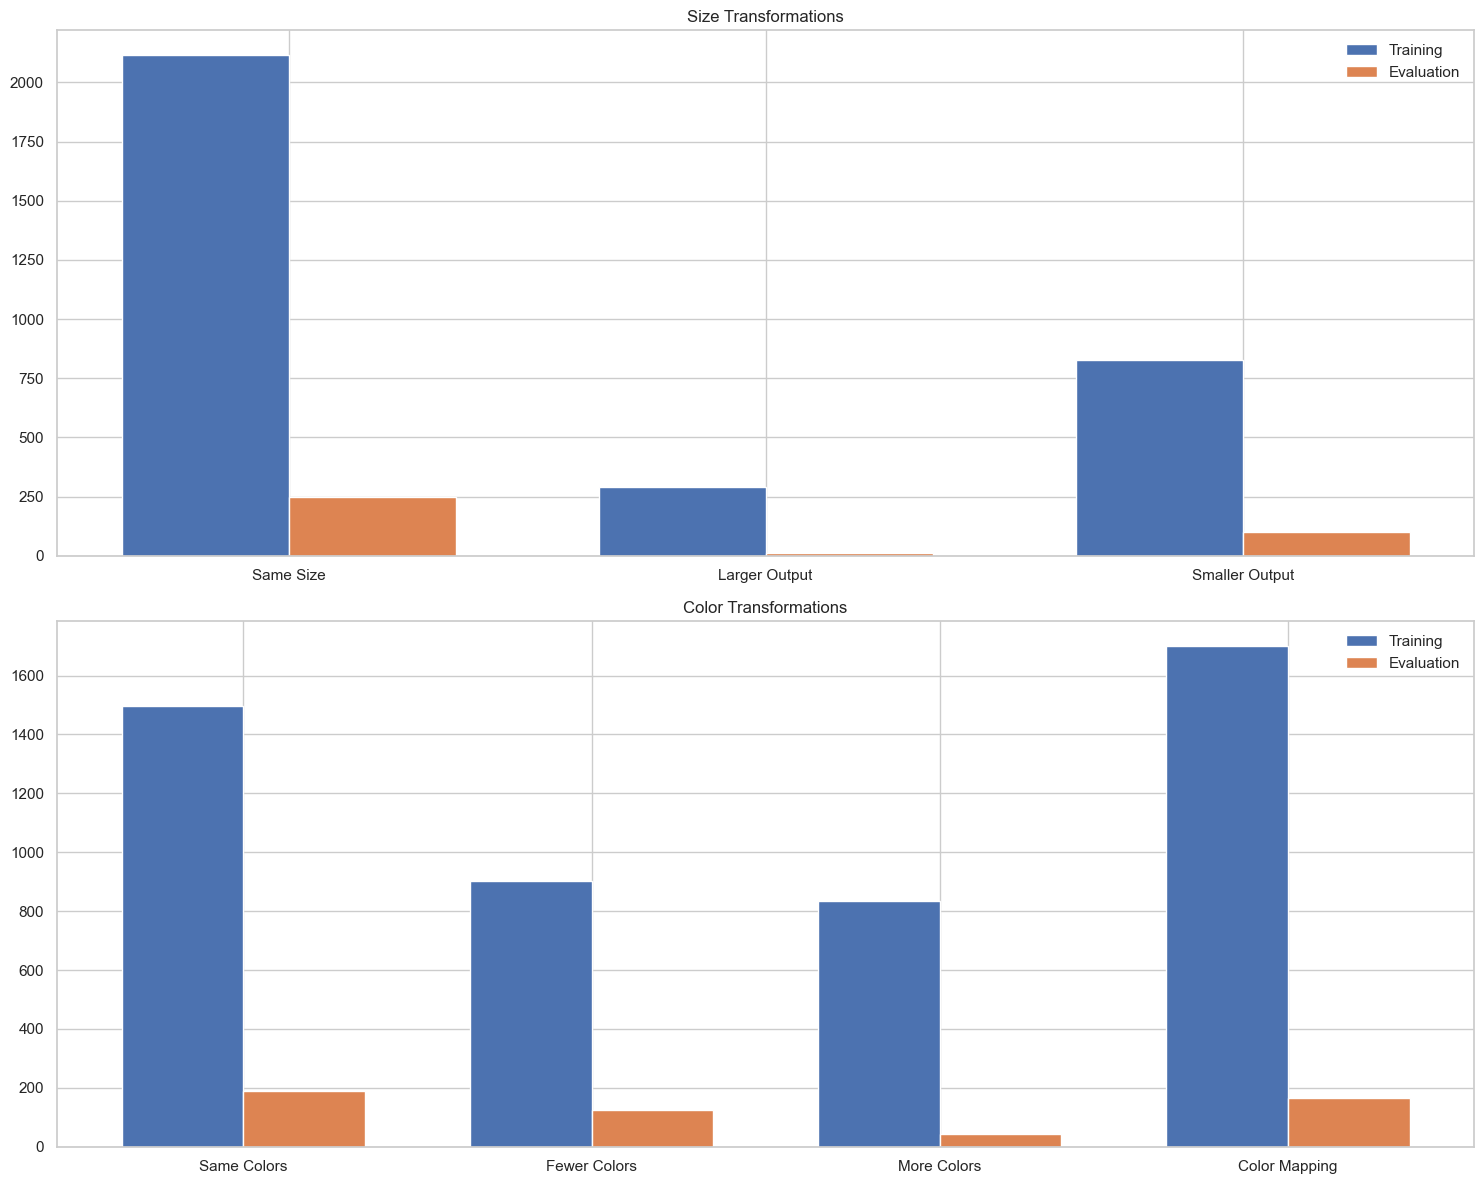

In [11]:
# Visualize transformation distributions
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Size transformations
size_categories = ['same_size', 'larger_output', 'smaller_output']
size_counts_train = [training_transforms[cat] for cat in size_categories]
size_counts_eval = [eval_transforms[cat] for cat in size_categories]

x = np.arange(len(size_categories))
width = 0.35

axes[0].bar(x - width/2, size_counts_train, width, label='Training')
axes[0].bar(x + width/2, size_counts_eval, width, label='Evaluation')
axes[0].set_title('Size Transformations')
axes[0].set_xticks(x)
axes[0].set_xticklabels([cat.replace('_', ' ').title() for cat in size_categories])
axes[0].legend()

# Color transformations
color_categories = ['same_colors', 'fewer_colors', 'more_colors', 'color_mapping']
color_counts_train = [training_transforms[cat] for cat in color_categories]
color_counts_eval = [eval_transforms[cat] for cat in color_categories]

x = np.arange(len(color_categories))

axes[1].bar(x - width/2, color_counts_train, width, label='Training')
axes[1].bar(x + width/2, color_counts_eval, width, label='Evaluation')
axes[1].set_title('Color Transformations')
axes[1].set_xticks(x)
axes[1].set_xticklabels([cat.replace('_', ' ').title() for cat in color_categories])
axes[1].legend()

plt.tight_layout()
plt.show()

## Pattern Categorization

Let's attempt to categorize some common patterns in the ARC tasks. This can help us understand what types of reasoning capabilities we'll need to develop.

In [12]:
def find_pattern_examples(num_examples=5):
    """Find examples of different pattern types."""
    
    # Define pattern types to look for
    pattern_categories = {
        'same_size_transformation': [],
        'object_counting': [],
        'size_scaling': [],
        'color_transformation': [],
        'pattern_completion': []
    }
    
    # Some basic heuristics to identify pattern types
    for task_id, task in training_challenges.items():
        train_pairs = task['train']
        
        # Skip if not enough examples
        if len(train_pairs) < 2:
            continue
        
        # Check sample pairs
        sample_input = train_pairs[0]['input']
        sample_output = train_pairs[0]['output']
        
        # Same size transformation check
        if len(sample_input) == len(sample_output) and len(sample_input[0]) == len(sample_output[0]):
            if len(pattern_categories['same_size_transformation']) < num_examples:
                pattern_categories['same_size_transformation'].append(task_id)
        
        # Object counting check (very simple heuristic - output grid is smaller)
        elif len(sample_output) == 1 and len(sample_output[0]) == 1:
            if len(pattern_categories['object_counting']) < num_examples:
                pattern_categories['object_counting'].append(task_id)
        
        # Size scaling check (output significantly larger or smaller)
        elif (len(sample_output) > 2 * len(sample_input) or 
              len(sample_output[0]) > 2 * len(sample_input[0]) or
              len(sample_input) > 2 * len(sample_output) or
              len(sample_input[0]) > 2 * len(sample_output[0])):
            if len(pattern_categories['size_scaling']) < num_examples:
                pattern_categories['size_scaling'].append(task_id)
        
        # Color transformation check
        input_colors = set([cell for row in sample_input for cell in row])
        output_colors = set([cell for row in sample_output for cell in row])
        if input_colors != output_colors:
            if len(pattern_categories['color_transformation']) < num_examples:
                pattern_categories['color_transformation'].append(task_id)
        
        # Pattern completion - could be tasks that don't fit other categories
        # This is a fallback category
        if (len(pattern_categories['pattern_completion']) < num_examples and 
            task_id not in [item for sublist in pattern_categories.values() for item in sublist]):
            pattern_categories['pattern_completion'].append(task_id)
    
    # Print found examples
    for category, task_ids in pattern_categories.items():
        print(f"\n=== {category.upper().replace('_', ' ')} EXAMPLES ===")
        for task_id in task_ids:
            print(f"Task ID: {task_id}")
    
    return pattern_categories

# Find examples of different pattern types
pattern_examples = find_pattern_examples(num_examples=3)


=== SAME SIZE TRANSFORMATION EXAMPLES ===
Task ID: 009d5c81
Task ID: 00d62c1b
Task ID: 00dbd492

=== OBJECT COUNTING EXAMPLES ===
Task ID: 1a2e2828
Task ID: 239be575
Task ID: 27a28665

=== SIZE SCALING EXAMPLES ===
Task ID: 00576224
Task ID: 007bbfb7
Task ID: 0520fde7

=== COLOR TRANSFORMATION EXAMPLES ===
Task ID: 009d5c81
Task ID: 00d62c1b
Task ID: 00dbd492

=== PATTERN COMPLETION EXAMPLES ===
Task ID: 017c7c7b
Task ID: 025d127b
Task ID: 03560426



=== EXAMPLE OF SAME SIZE TRANSFORMATION ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


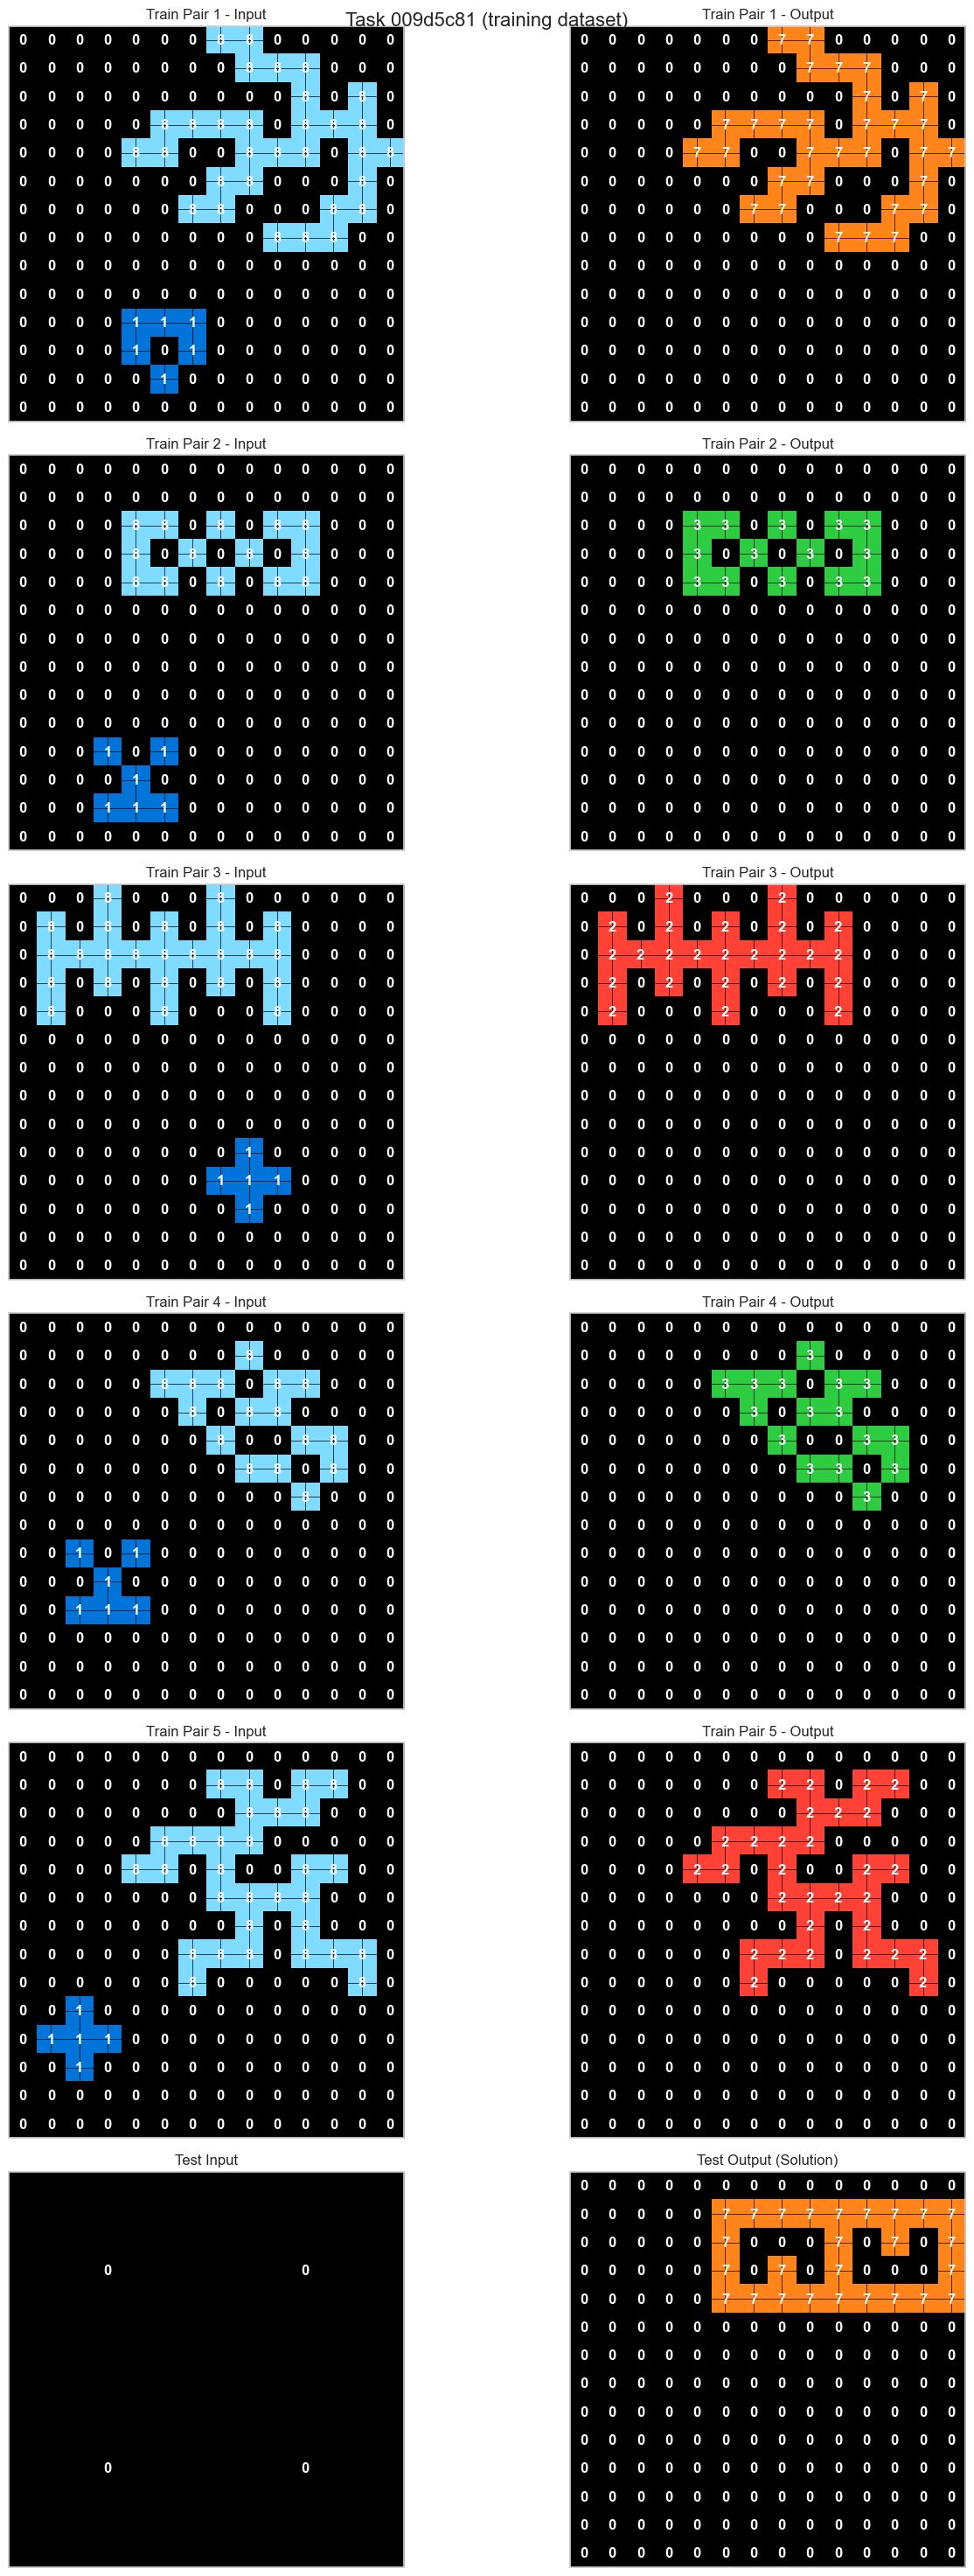


=== EXAMPLE OF OBJECT COUNTING ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


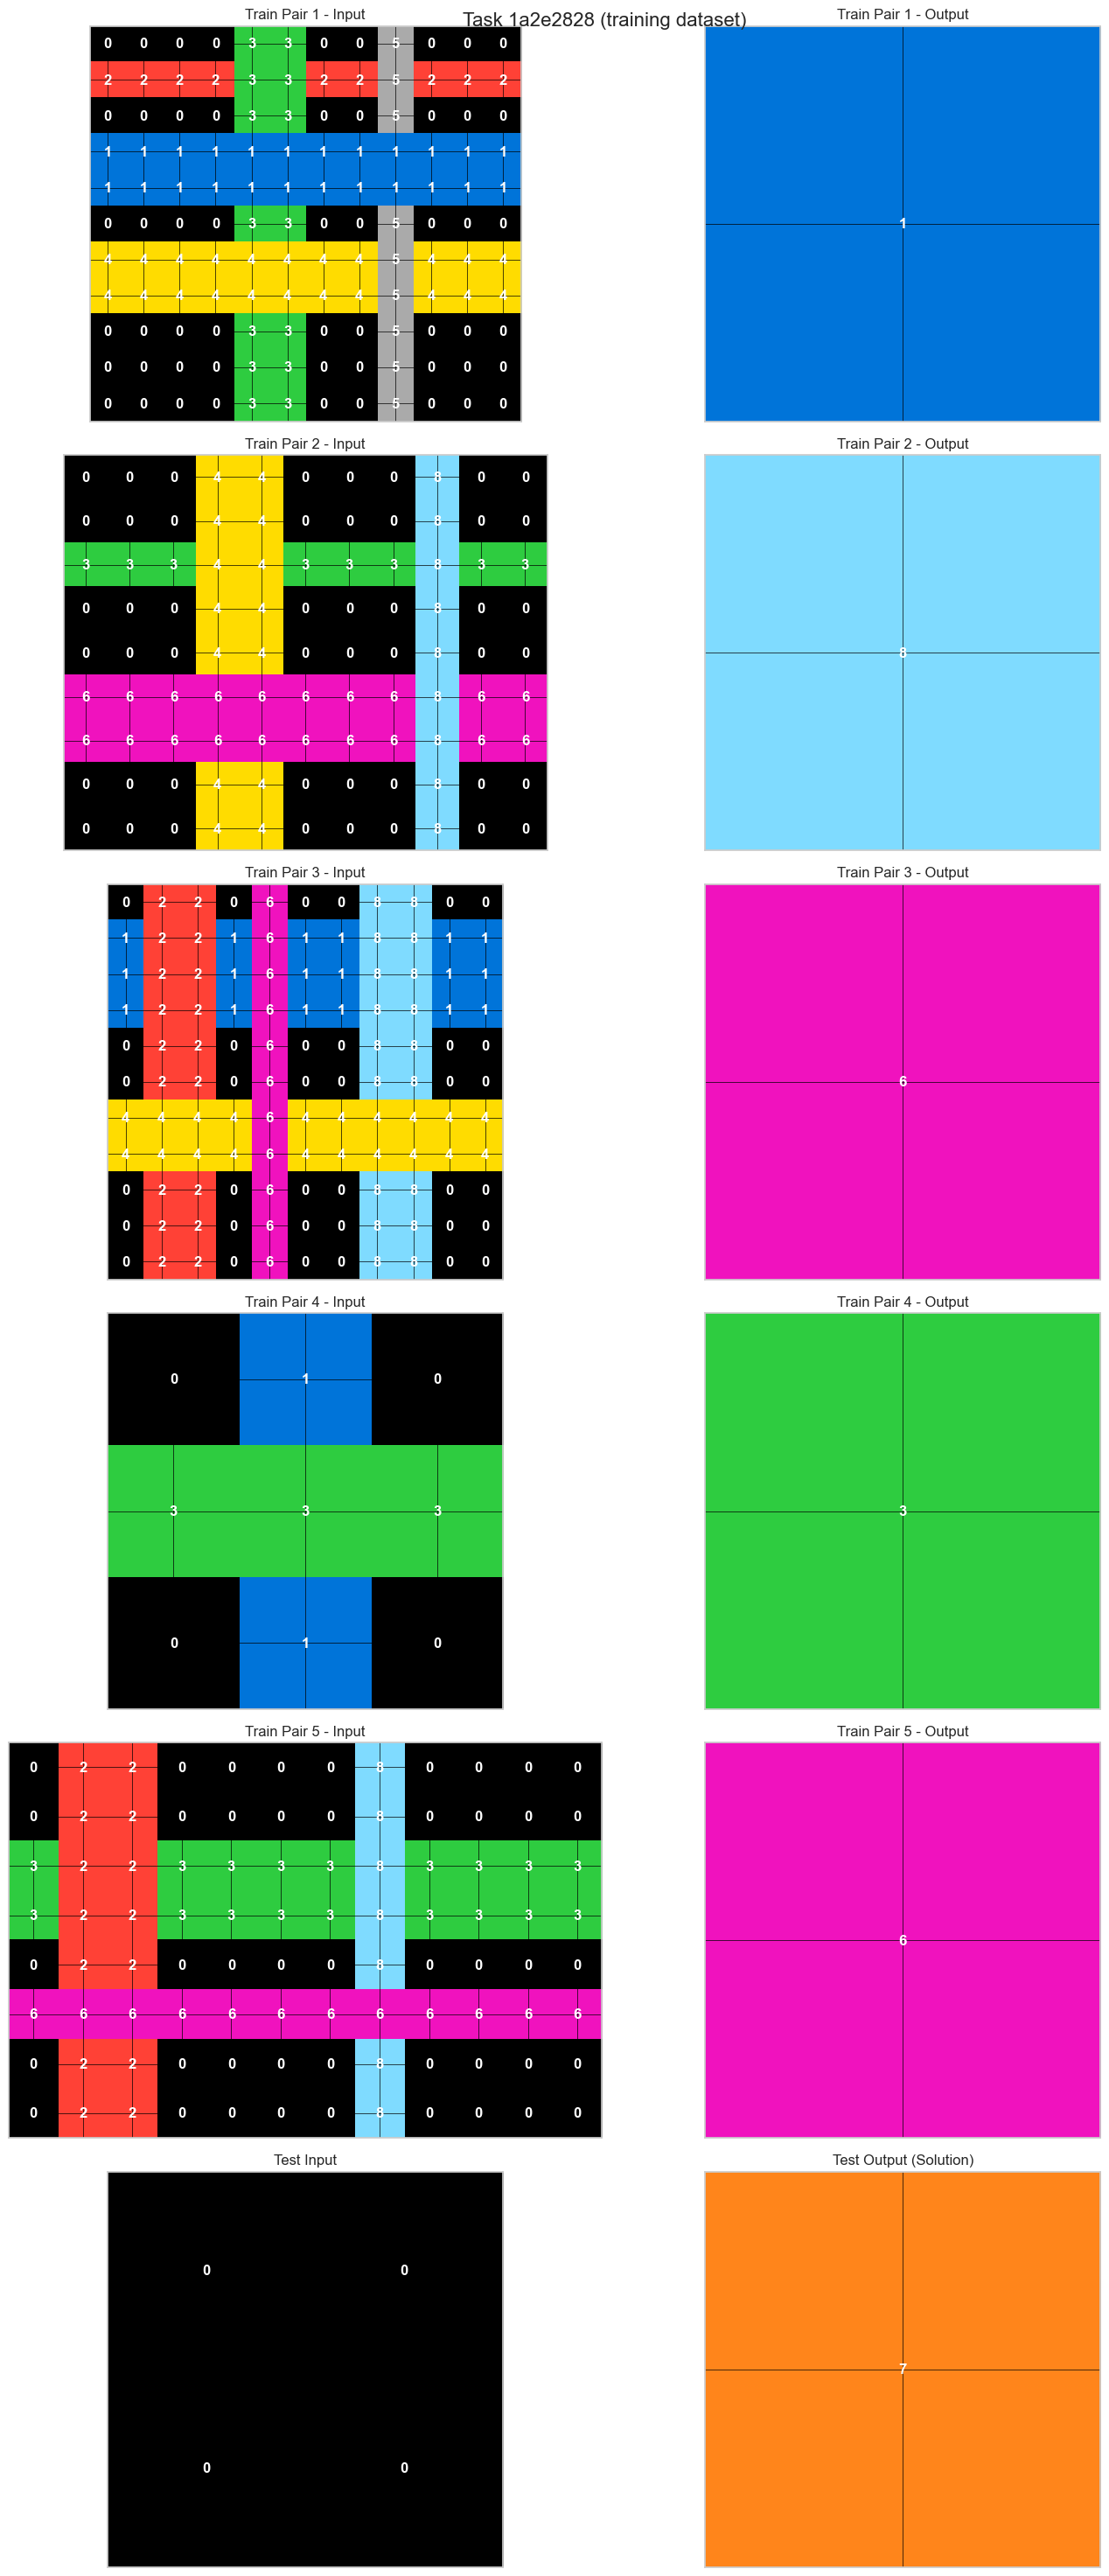


=== EXAMPLE OF SIZE SCALING ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


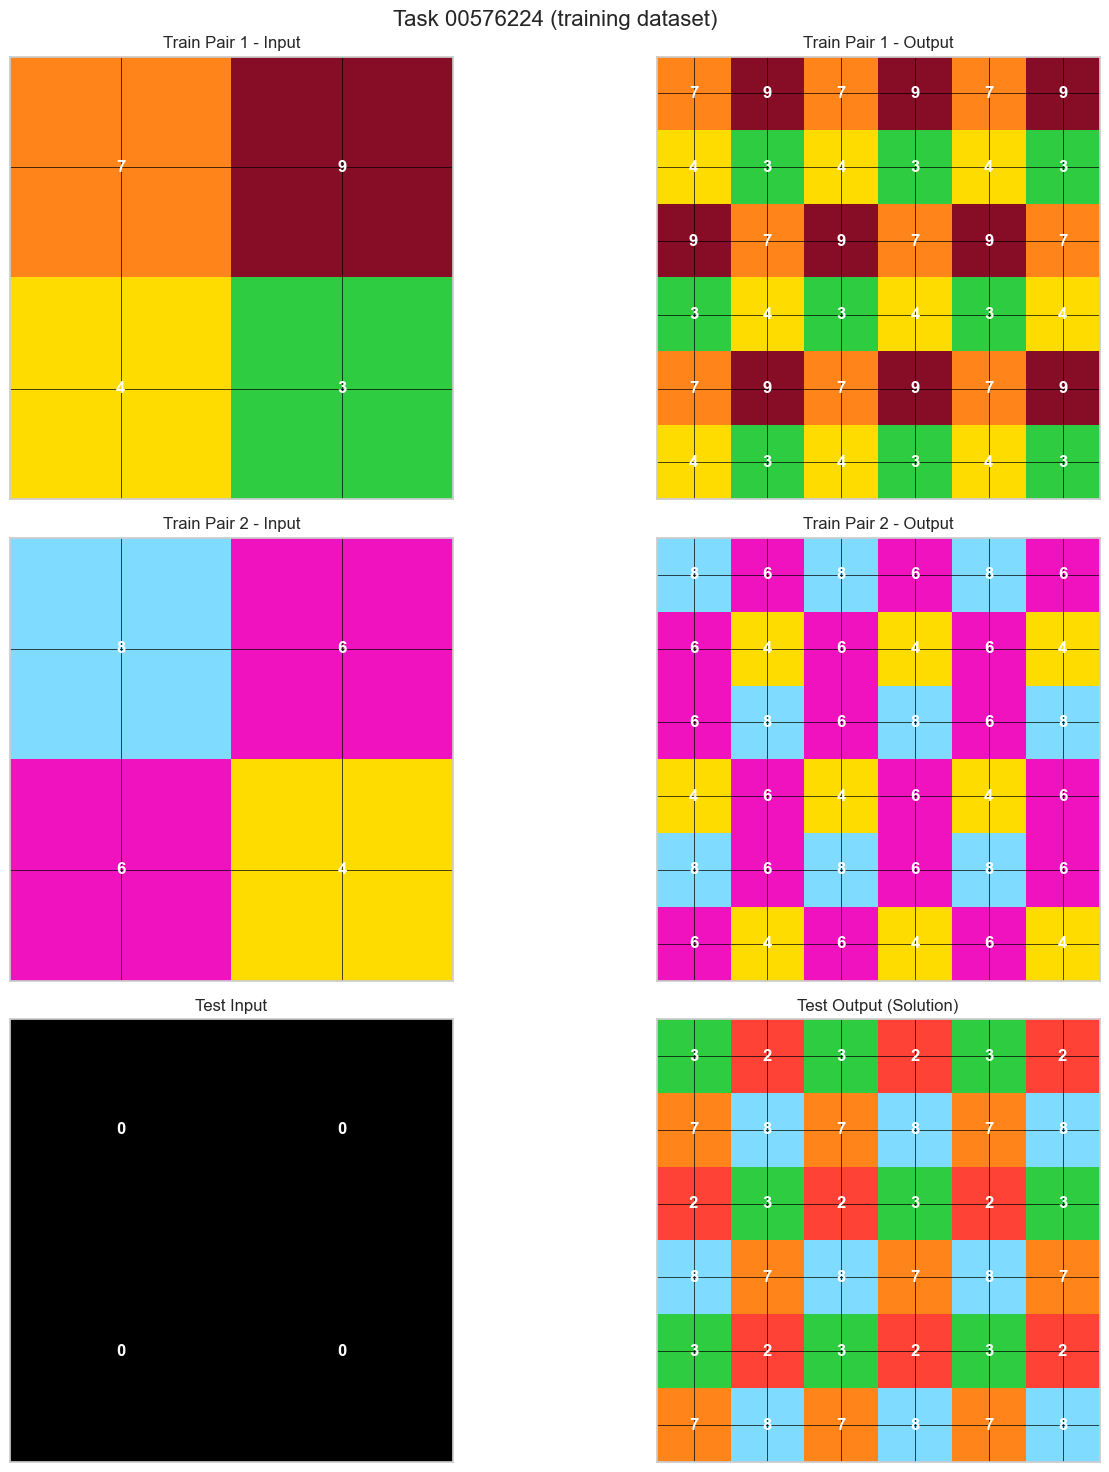


=== EXAMPLE OF COLOR TRANSFORMATION ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


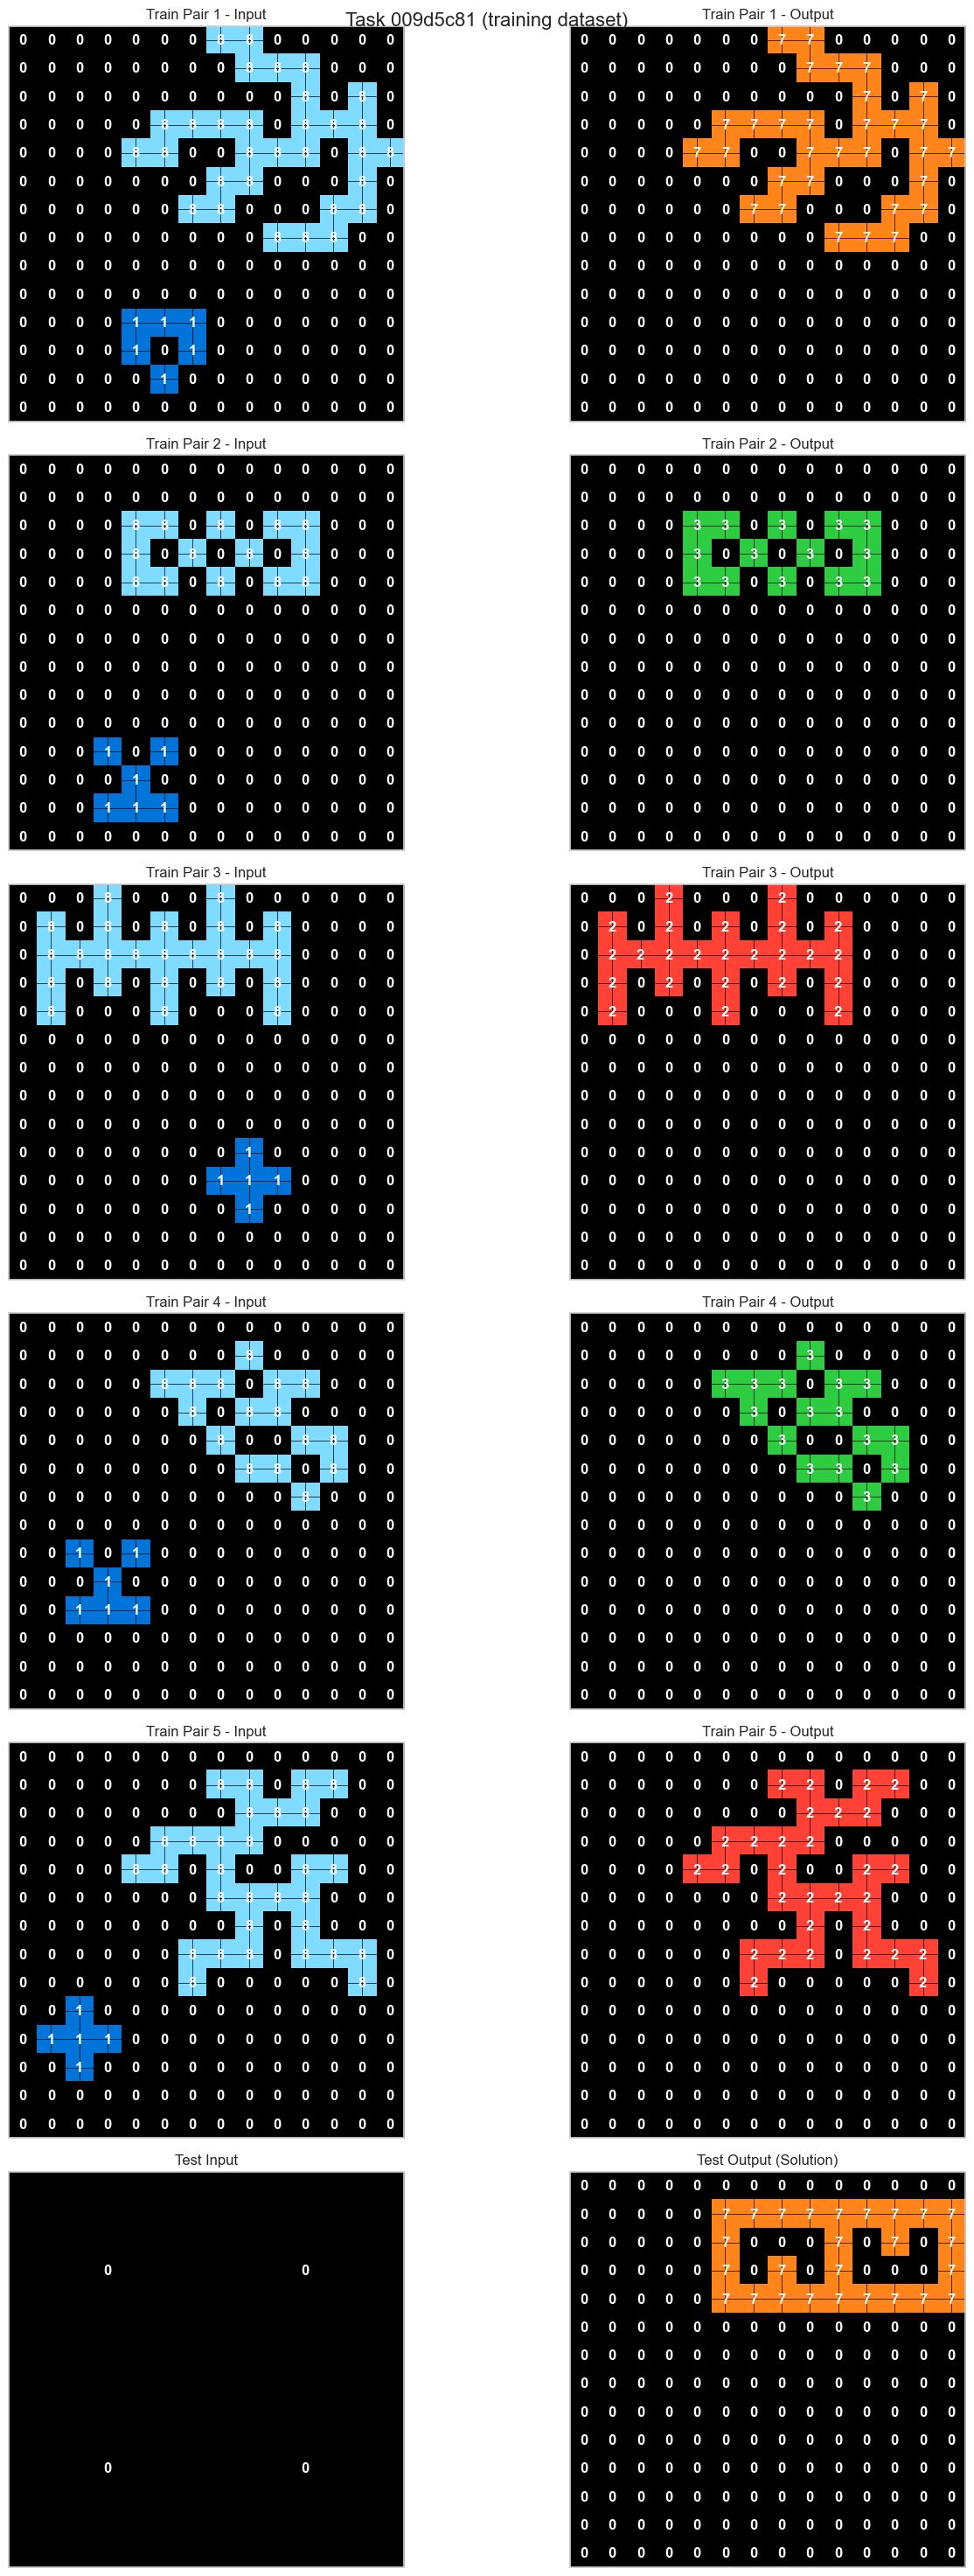


=== EXAMPLE OF PATTERN COMPLETION ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


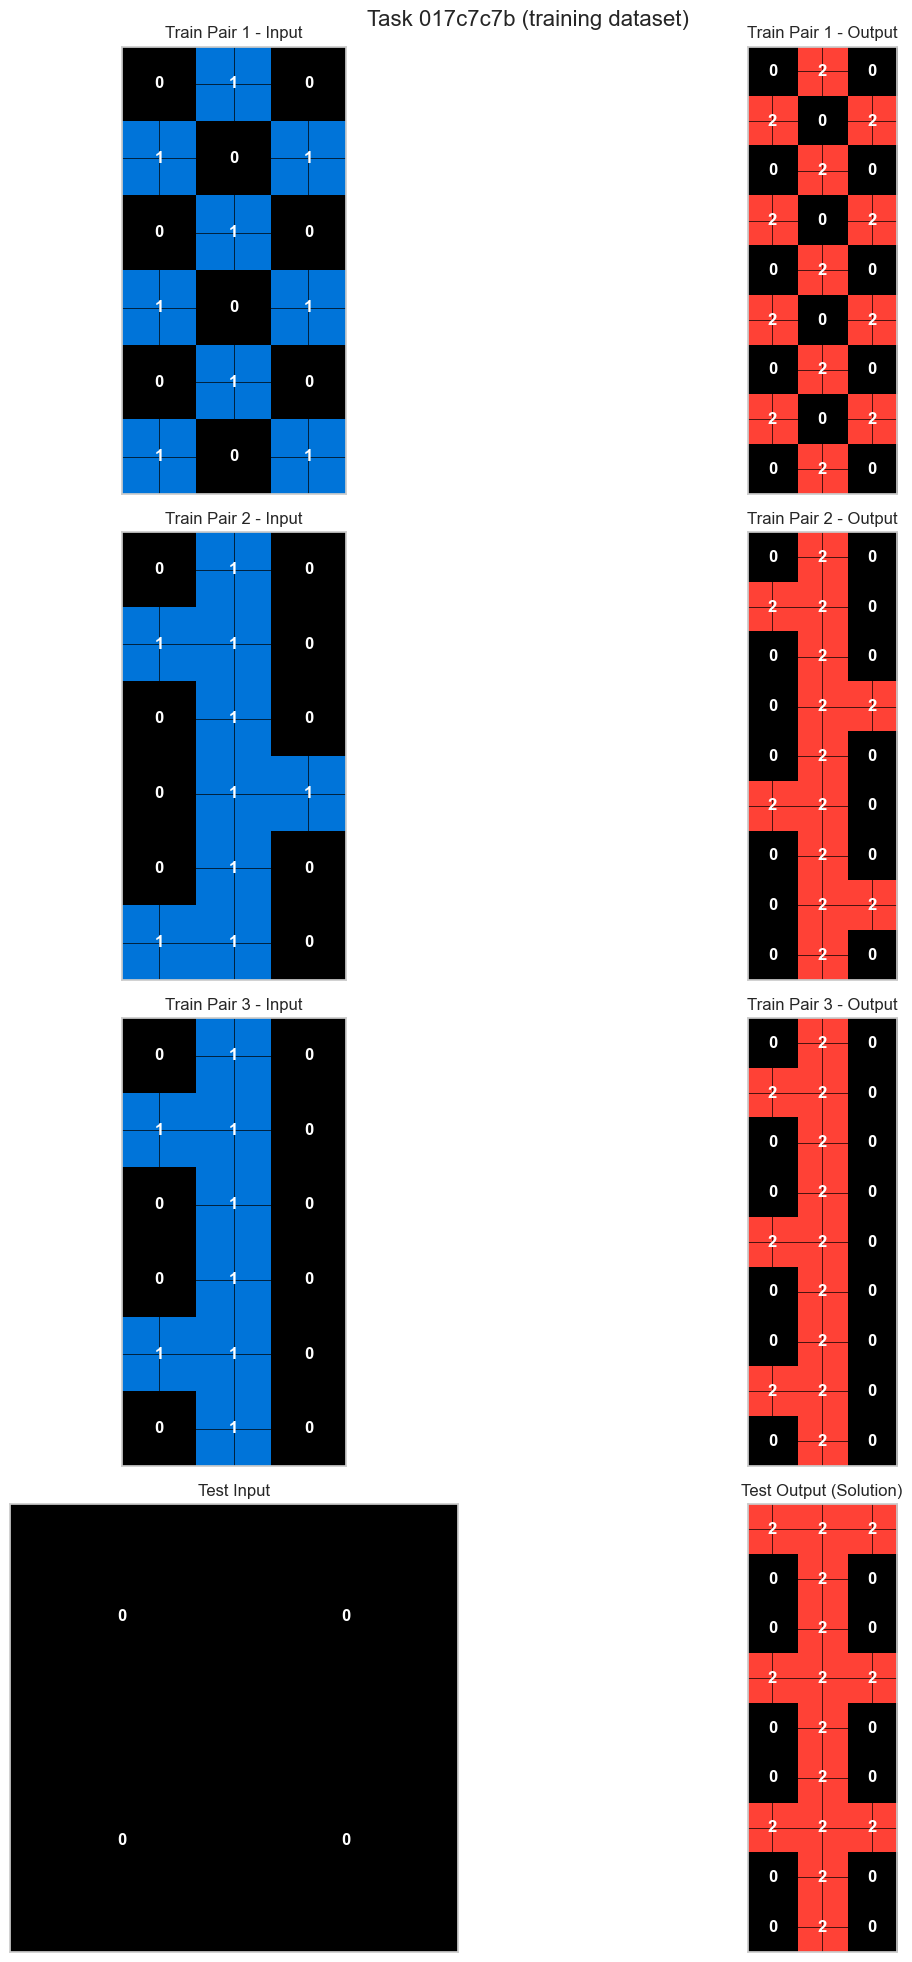

In [13]:
# Visualize examples from different pattern categories
def visualize_pattern_category(category, pattern_examples, max_examples=2):
    """Visualize examples from a pattern category."""
    task_ids = pattern_examples[category]
    if not task_ids:
        print(f"No examples found for category: {category}")
        return
    
    # Limit the number of examples to display
    task_ids = task_ids[:max_examples]
    
    for task_id in task_ids:
        print(f"\n=== EXAMPLE OF {category.upper().replace('_', ' ')} ===")
        visualize_task(task_id, 'training')

# Visualize examples from each pattern category
categories = list(pattern_examples.keys())
for category in categories:
    visualize_pattern_category(category, pattern_examples, max_examples=1)

## Task Browser Function

Let's create a function that allows us to browse through tasks easily.


=== RANDOM TASK 1/3 (ID: a8d7556c) ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


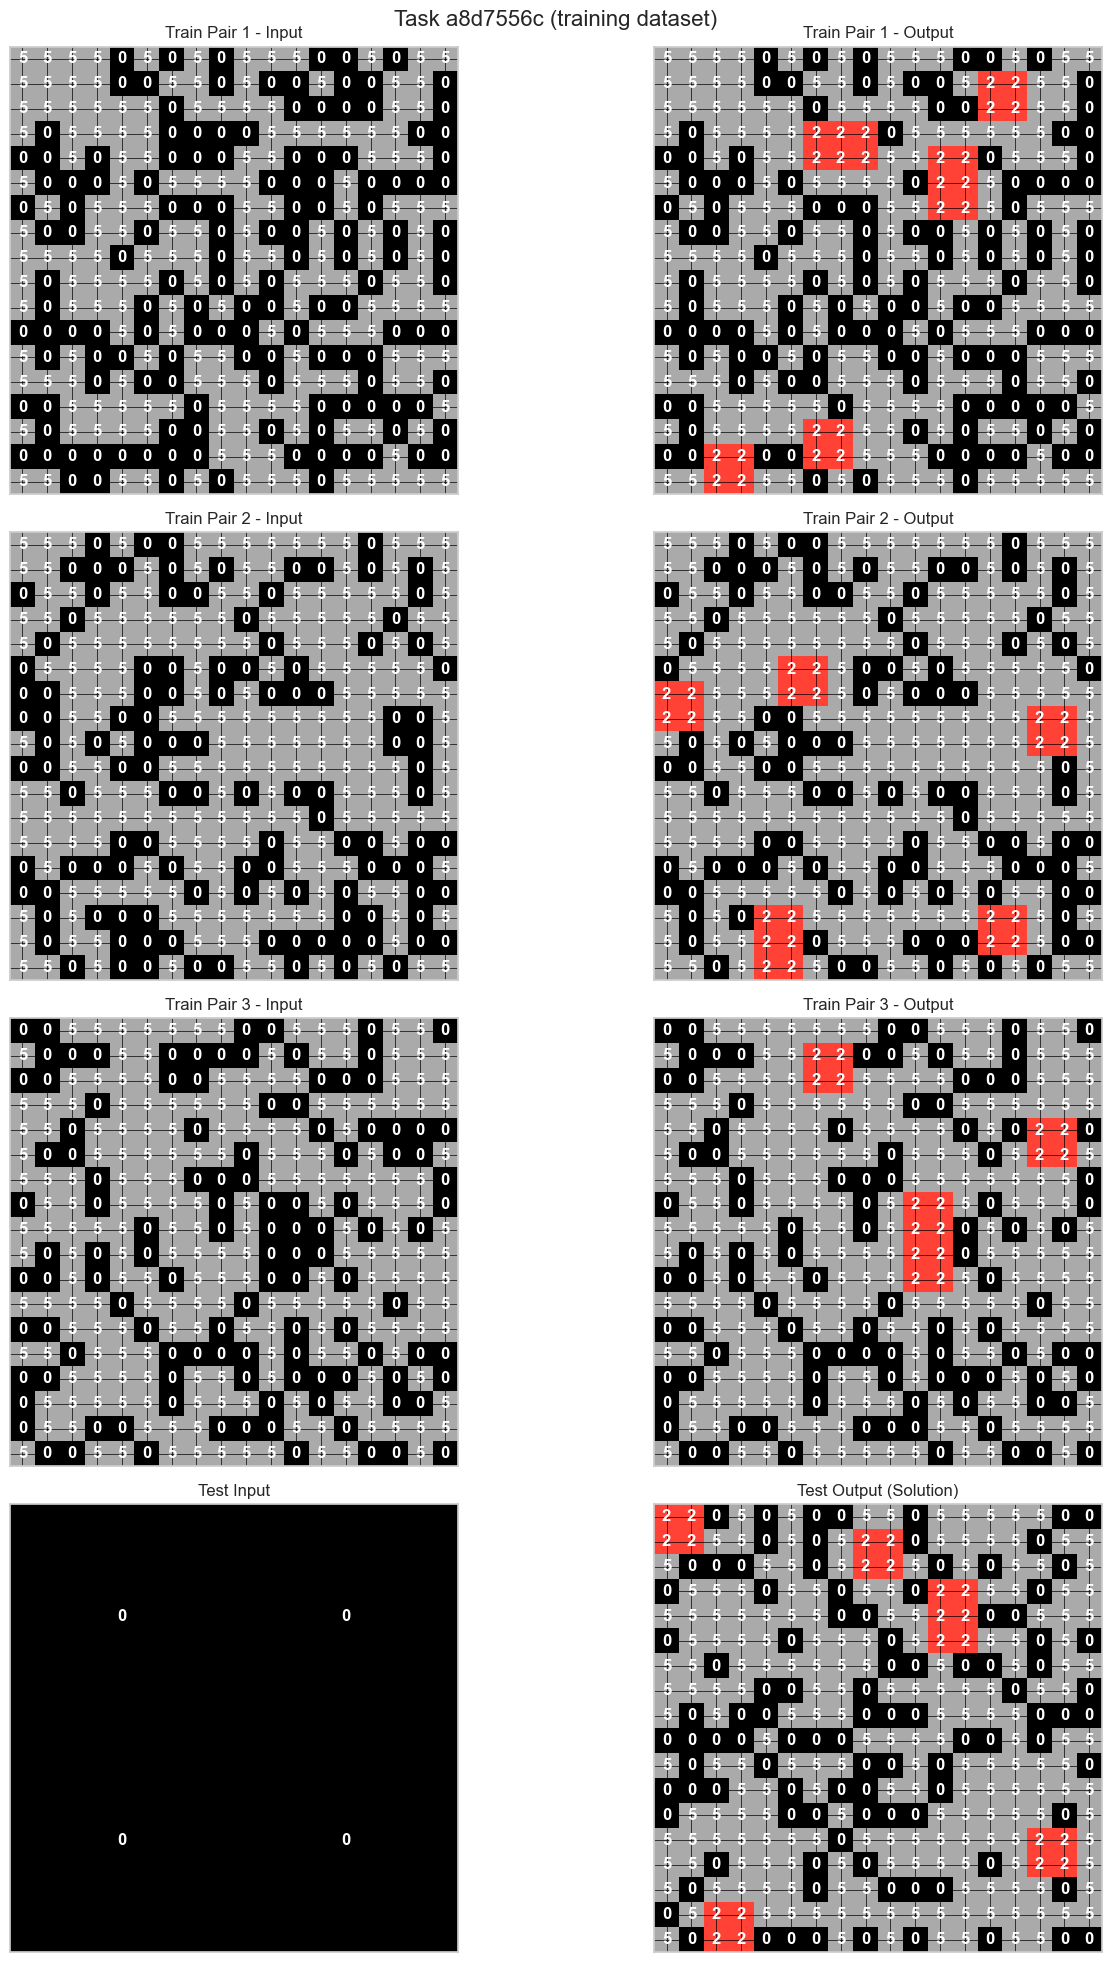


=== RANDOM TASK 2/3 (ID: 7e2bad24) ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


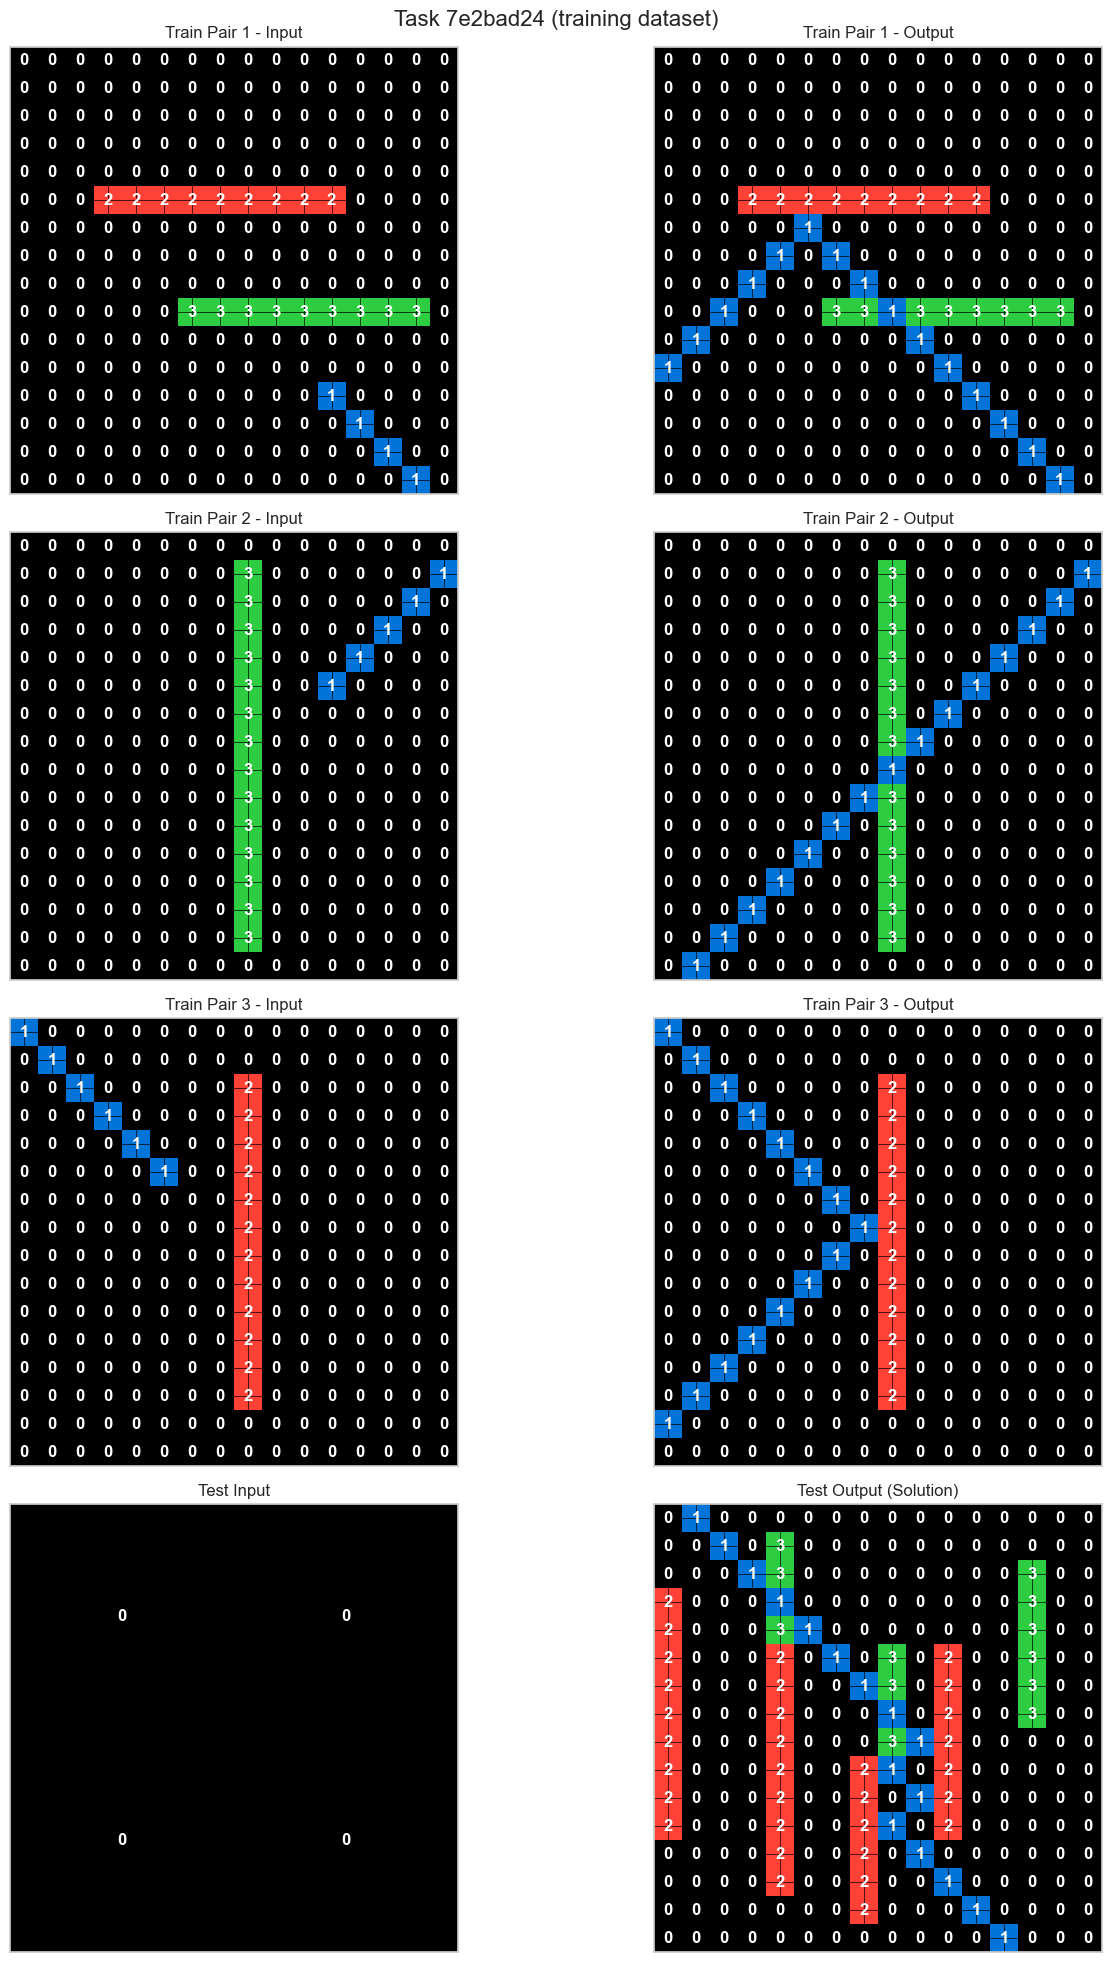


=== RANDOM TASK 3/3 (ID: 0e671a1a) ===
Task structure: <class 'dict'>
Task keys: ['train', 'test']


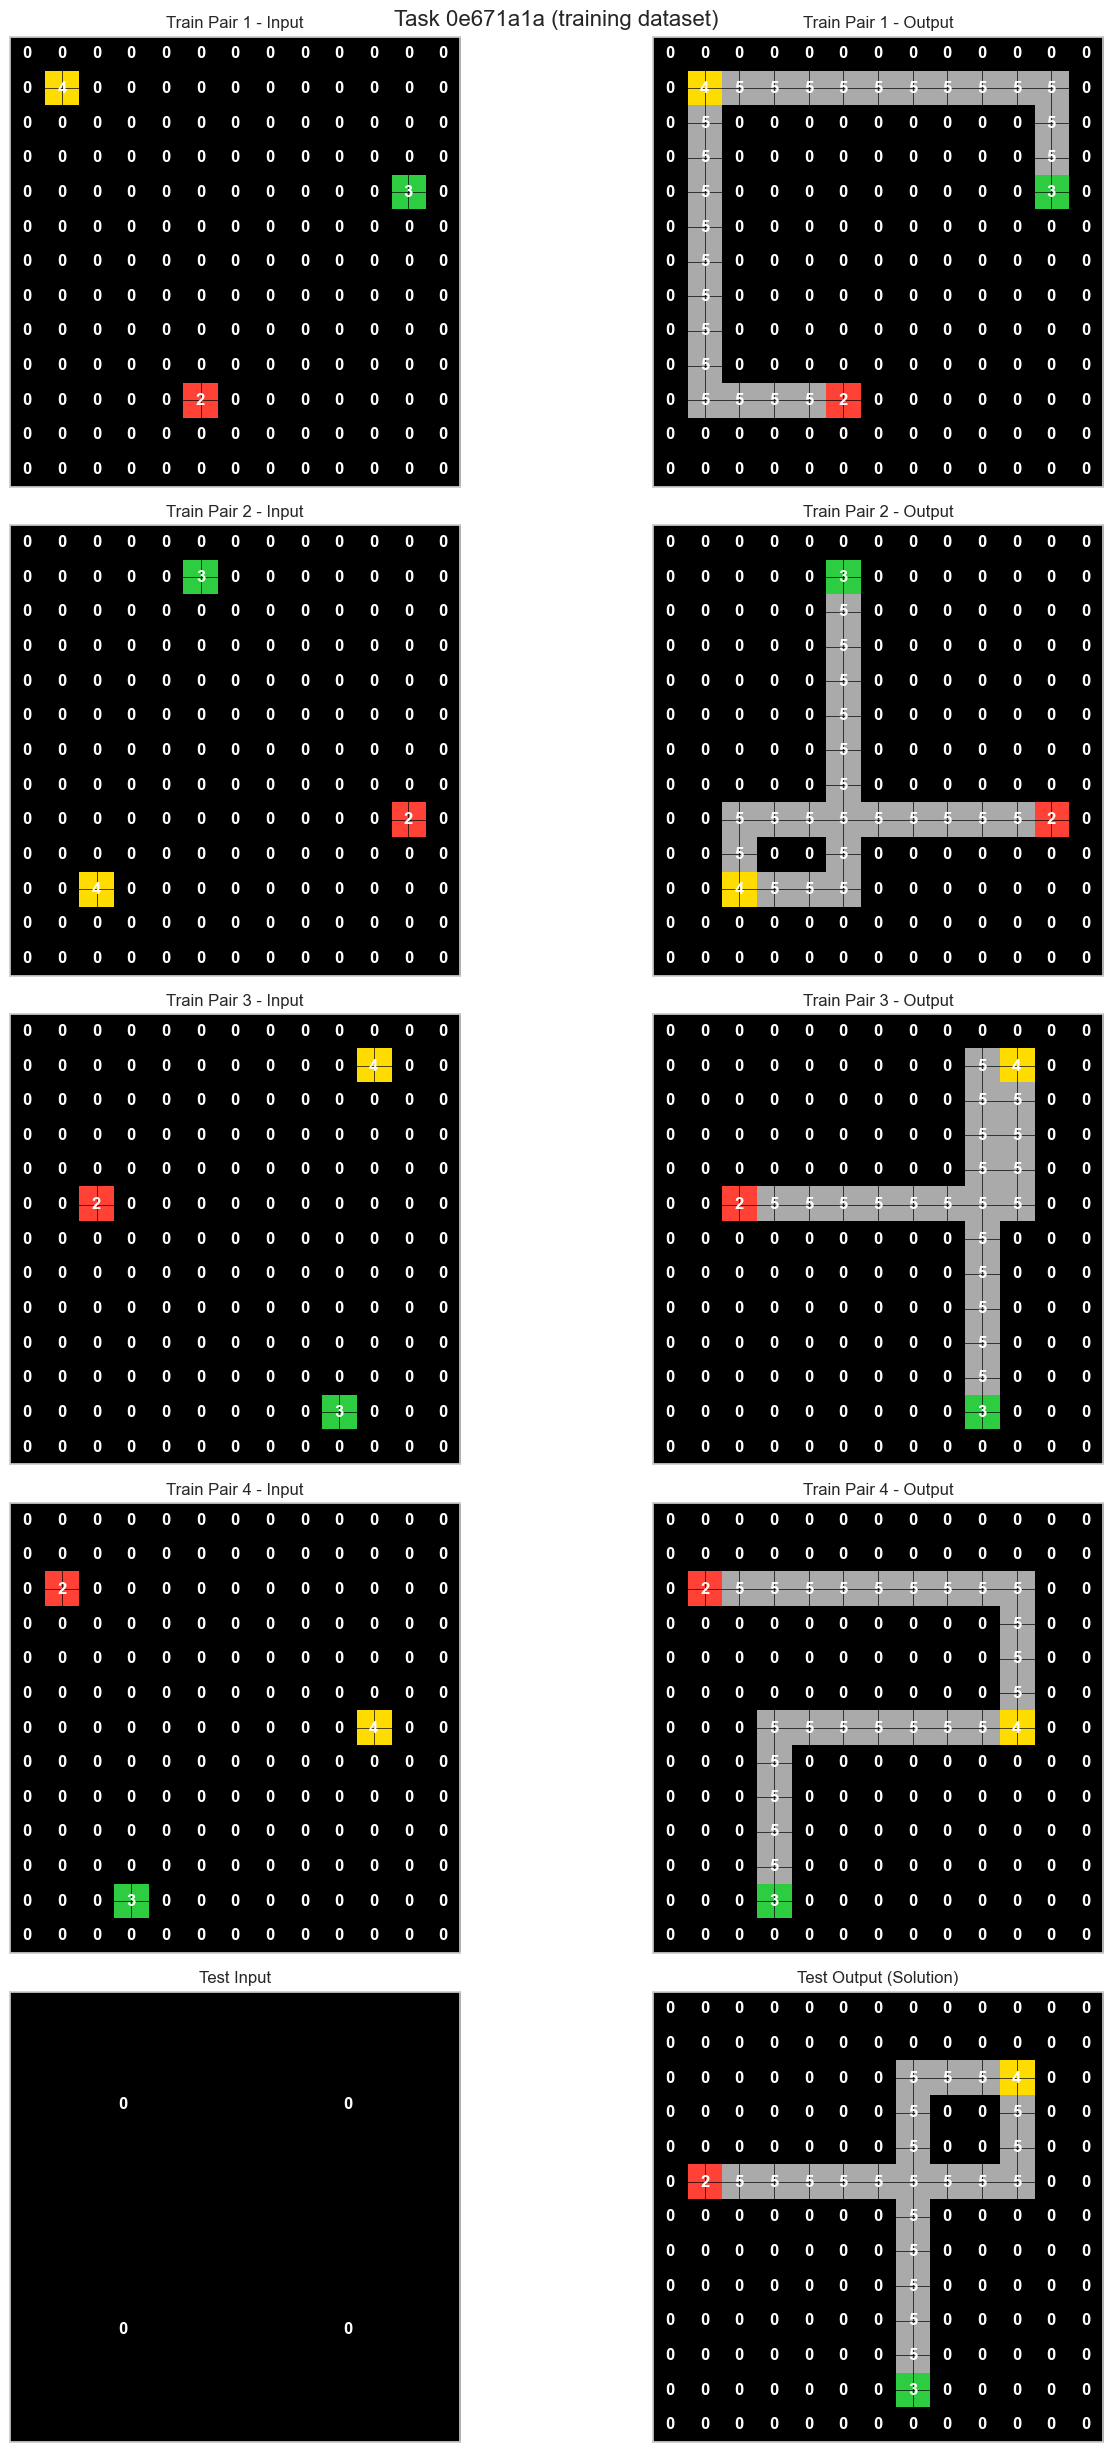

In [14]:
def browse_random_tasks(dataset='training', num_tasks=5):
    """Browse through random tasks from the dataset."""
    if dataset == 'training':
        challenges = training_challenges
    elif dataset == 'eval':
        challenges = eval_challenges
    elif dataset == 'test':
        challenges = test_challenges
    else:
        print(f"Unknown dataset: {dataset}")
        return
    
    task_ids = list(challenges.keys())
    if num_tasks > len(task_ids):
        num_tasks = len(task_ids)
    
    sampled_tasks = random.sample(task_ids, num_tasks)
    
    for i, task_id in enumerate(sampled_tasks):
        print(f"\n=== RANDOM TASK {i+1}/{num_tasks} (ID: {task_id}) ===")
        visualize_task(task_id, dataset)

# Browse through a few random tasks
browse_random_tasks('training', num_tasks=3)

## Next Steps and Implementation Plan

Based on our exploration, here's a plan for approaching the ARC Prize challenge:

1. **Grid Representation Framework**
   - Create a comprehensive Grid class with methods for:
     - Basic transformations (rotate, reflect, crop, etc.)
     - Feature extraction (color counts, pattern detection)
     - Comparison operations (similarity metrics)
   
2. **Pattern Detection Library**
   - Implement detectors for:
     - Geometric shapes and patterns
     - Color transformations and mappings
     - Structural relationships between elements
     - Symmetry and repetition patterns

3. **Transformation Engine**
   - Create a system to:
     - Detect transformations between input and output
     - Classify transformation types
     - Generate new outputs by applying transformations
     - Compose multiple transformations

4. **Rule Induction System**
   - Build mechanisms for:
     - Generating candidate rules from examples
     - Evaluating rule performance on examples
     - Generalizing rules to new cases
     - Selecting the best rule from candidates

5. **Search-Based Solvers**
   - Implement:
     - Tree search for transformation sequences
     - Monte Carlo Tree Search for exploration
     - Heuristic evaluation functions
     - Path optimization algorithms

6. **Neural Components**
   - Develop:
     - Grid encoders and decoders
     - Pattern recognition networks
     - Few-shot learning mechanisms
     - Self-supervised pretraining

7. **Hybrid System Integration**
   - Create a framework to:
     - Select appropriate solution methods per task
     - Ensemble multiple approaches
     - Validate solutions against examples
     - Generate multiple solution candidates

8. **Evaluation Framework**
   - Build tools to:
     - Test solution methods systematically
     - Analyze error patterns
     - Benchmark against human performance
     - Identify areas for improvement